In [1]:
suppressPackageStartupMessages({
    library(Matrix)
    library(ggplot2)
    library(cygnus)
    library(dplyr)
    library(data.table)
    library(purrr)
    library(ggthemes)
    library(viridis)
    library(patchwork)
    library(glue)
    library(sf)
    library(ComplexHeatmap)
    library(RSpectra)
    library(mclust)
    library(Seurat)
    })

fig.size <- function(w,h) {
    options(repr.plot.height = h, repr.plot.width = w)
}

## What are the main hub type for each spatial cluster?

In [114]:
dmt1 = readRDS('outputs/dmt1.rds')
aggs1 = readRDS('outputs/aggs1.rds')


In [115]:
head(dmt1$pts)

X,Y,ORIG_ID,type_lvl1,type_lvl2,hubID,f,agg_id,spatial_cluster
<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>,<dbl>,<int>,<fct>
7086.414,79.414864,1,Epithelial,Epithelial,H260,1.189615,2,0
7087.515,-21.805606,3,Epithelial,Epithelial,H260,1.074691,1,13
7099.331,-17.703966,4,Epithelial,Epithelial,H260,2.322399,1,13
7100.477,-9.060024,5,Epithelial,Epithelial,H260,1.236350,1,13
7093.215,-5.783358,6,Epithelial,Epithelial,H260,1.425693,1,13
7086.925,-4.925823,7,Epithelial,Epithelial,H260,1.420925,3832,1


In [111]:
max(dmt1$pts$ORIG_ID)

[1] 664608

In [5]:
hub_metadata = read.csv("data/VizgenLungHacohen/hubs/meta_data.csv")
cell_metadata = read.csv("data/VizgenLungHacohen/cells/meta_data.csv")
head(hub_metadata)

,library,hubType,ID,ntiles,X,Y,area
,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,Sample05,tumor,H1,6381,7156.30,2177.311,15874262.765
2,Sample05,tumor,H3,57,10452.11,2271.211,142500.018
3,Sample05,tumor,H5,2,10583.37,1988.356,5000.001
4,Sample05,tumor,H6,27,10906.24,1136.163,67500.009
5,Sample05,tumor,H8,45,11192.59,1516.332,112500.014
6,Sample05,tumor,H10,45,11311.39,2117.090,112500.014


In [64]:
tail(cell_metadata)

,cell,library,X,Y,ntx,ngene,nblank,type_lvl1,type_lvl2,UMAP1_all,UMAP2_all,UMAP1_immune,UMAP2_immune,hubID
,<int>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1591336,2295192,Sample05,10857.127,3840.023,12,11,0,Plasma,Plasma,-1.8981564,-0.345314412,NA,NA,H109
1591337,2295193,Sample05,10814.877,3939.874,10,9,0,Epithelial,Epithelial,0.9241133,0.108141036,NA,NA,H1
1591338,2295194,Sample05,10833.919,3926.973,11,10,0,,,-1.6365825,0.551391484,NA,NA,H1
1591339,2295195,Sample05,10907.032,2927.350,10,10,0,,,-1.6076172,-0.009691844,NA,NA,H96
1591340,2295197,Sample05,9874.502,3045.113,11,11,0,Epithelial,Epithelial,0.8154577,-0.611378311,NA,NA,H181
1591341,2295198,Sample05,10308.977,3554.827,14,13,0,Epithelial,Epithelial,1.7082864,-0.188187017,NA,NA,H1


In [89]:
# Fix a bug regarding the original ID of the cell in the metadata. It should be the 
cell_metadata$cell_id = as.integer(rownames(cell_metadata))

head(cell_metadata)

,cell,library,X,Y,ntx,ngene,nblank,type_lvl1,type_lvl2,UMAP1_all,UMAP2_all,UMAP1_immune,UMAP2_immune,hubID,cell_id
,<int>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
1,1,Patient001,7086.414,79.414864,30,23,0,Epithelial,Epithelial,0.6343959,0.154633419,NA,NA,H260,1
2,2,Patient001,7090.282,-74.397942,16,14,0,Lymphocyte,B,-1.5597103,0.002063452,0.6360152,0.5448408,H260,2
3,3,Patient001,7087.515,-21.805606,15,12,1,Epithelial,Epithelial,0.8468631,0.231922747,NA,NA,H260,3
4,4,Patient001,7099.331,-17.703966,29,20,0,Epithelial,Epithelial,1.0996897,0.321722211,NA,NA,H260,4
5,5,Patient001,7100.477,-9.060024,29,16,1,Epithelial,Epithelial,0.9649788,0.678280176,NA,NA,H260,5
6,6,Patient001,7093.215,-5.783358,31,22,0,Epithelial,Epithelial,1.0787352,0.278981359,NA,NA,H260,6


In [116]:
#merge_df <- merge(dmt1$pts, cell_metadata[cell_metadata$library=='Patient001',c("cell_id","hubID")], by.x="ORIG_ID", by.y="cell_id")
merge_df <- merge(dmt1$pts, hub_metadata[hub_metadata$library=='Patient001', c("hubType", "ID")], by.x="hubID", by.y="ID")
merge_df = merge_df[,c('ORIG_ID', "X","Y","type_lvl1",'type_lvl2', 'f', 'agg_id', 'spatial_cluster', 'hubID', 'hubType')]
head(merge_df)

ORIG_ID,X,Y,type_lvl1,type_lvl2,f,agg_id,spatial_cluster,hubID,hubType
<int>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<fct>,<chr>,<chr>
1,7086.414,79.414864,Epithelial,Epithelial,1.189615,2,0,H260,tumor
3,7087.515,-21.805606,Epithelial,Epithelial,1.074691,1,13,H260,tumor
4,7099.331,-17.703966,Epithelial,Epithelial,2.322399,1,13,H260,tumor
5,7100.477,-9.060024,Epithelial,Epithelial,1.236350,1,13,H260,tumor
6,7093.215,-5.783358,Epithelial,Epithelial,1.425693,1,13,H260,tumor
7,7086.925,-4.925823,Epithelial,Epithelial,1.420925,3832,1,H260,tumor


In [117]:
tail(merge_df)

ORIG_ID,X,Y,type_lvl1,type_lvl2,f,agg_id,spatial_cluster,hubID,hubType
<int>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<fct>,<chr>,<chr>
642670,12457.07,10471.59,Lymphocyte,CD4 T,1.516320,10571,6,H853,hybrid_hub
642671,12450.31,10349.26,,,1.968764,10562,6,H853,hybrid_hub
642672,12453.64,10410.00,,,1.822244,20932,6,H853,hybrid_hub
642673,12450.90,10448.80,Fibroblast,Fibroblast,1.228548,10571,6,H853,hybrid_hub
642957,12427.47,10390.08,Lymphocyte,CD4 T,1.583628,20932,6,H853,hybrid_hub
642964,12441.31,10357.79,,,1.819806,10562,6,H853,hybrid_hub


In [118]:
dim(dmt1$pts)

[1] 648857      9

In [119]:
dim(cell_metadata[cell_metadata$library=='Patient001', ])

[1] 664608     15

In [120]:
write.csv(merge_df, "outputs/p1_merge_metadata.csv")

Warning message:
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is superseded and is no longer actively developed, and this redirection is now deprecated. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace, i.e. reshape2::melt(contingency). In the next version, this warning will become an error.”


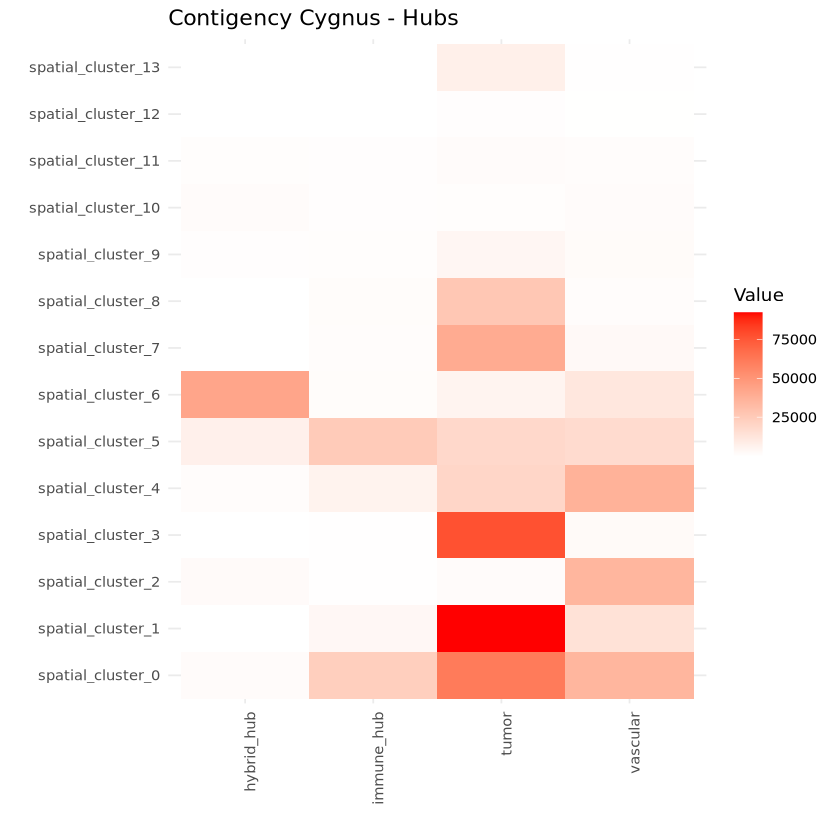

In [121]:
contingency = matrix(table(merge_df[,c('spatial_cluster', 'hubType')]), nrow=14)
colnames(contingency) <- c("hybrid_hub", "immune_hub", "tumor", "vascular")
row.names(contingency) <- paste("spatial_cluster", 0:13, sep="_")
contingency_melt = melt(contingency)


ggplot(contingency_melt, aes(x=Var2, y=Var1, fill=value)) +
    geom_tile() +
    scale_fill_gradient(low='white', high='red') +
    theme_minimal() +
    theme(axis.text.x = element_text(angle=90, hjust=1)) +
    labs(x='', y='', title='Contigency Cygnus - Hubs', fill='Value')

In [122]:
contingency

,hybrid_hub,immune_hub,tumor,vascular
spatial_cluster_0,1773,23203,61590,35111
spatial_cluster_1,139,3666,92391,14227
spatial_cluster_2,2233,451,1881,35169
spatial_cluster_3,6,429,77345,2612
spatial_cluster_4,1461,5860,19623,37093
spatial_cluster_5,7137,25289,18711,17220
spatial_cluster_6,42894,1669,5459,11598
spatial_cluster_7,58,1501,40356,2827
spatial_cluster_8,5,1680,26938,1424
spatial_cluster_9,757,1173,4396,2142


In [54]:
dim(colSums(contingency))

NULL

In [123]:
# Normalize across column
colnorm_contin = sweep(contingency,2, colSums(contingency), "/")
colnorm_contin

,hybrid_hub,immune_hub,tumor,vascular
spatial_cluster_0,2.990588e-02,0.347865849,0.171267922,0.215064499
spatial_cluster_1,2.344567e-03,0.054961695,0.256918568,0.087144275
spatial_cluster_2,3.766488e-02,0.006761518,0.005230637,0.215419765
spatial_cluster_3,1.012043e-04,0.006431688,0.215079030,0.015999216
spatial_cluster_4,2.464325e-02,0.087854755,0.054567145,0.227204792
spatial_cluster_5,1.203826e-01,0.379139743,0.052031078,0.105477220
spatial_cluster_6,7.235098e-01,0.025022114,0.015180250,0.071040929
spatial_cluster_7,9.783085e-04,0.022503411,0.112220949,0.017316150
spatial_cluster_8,8.433694e-05,0.025187029,0.074908513,0.008722390
spatial_cluster_9,1.276861e-02,0.017585943,0.012224286,0.013120337


In [141]:
plot_heatmap <- function(data, title='Contigency Cygnus - Hubs'){
    melt_data = melt(data)
    ggplot(melt_data, aes(x=Var2, y=Var1, fill=value)) +
    geom_tile() +
    geom_text(aes(label = round(value, 2)), size = 4) +
    scale_fill_gradient(low='white', high='red') +
    theme_minimal() +
    theme(axis.text.x = element_text(angle=90, hjust=1)) +
    labs(x='', y='', title=title, fill='Value')
}


Warning message:
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is superseded and is no longer actively developed, and this redirection is now deprecated. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace, i.e. reshape2::melt(data). In the next version, this warning will become an error.”


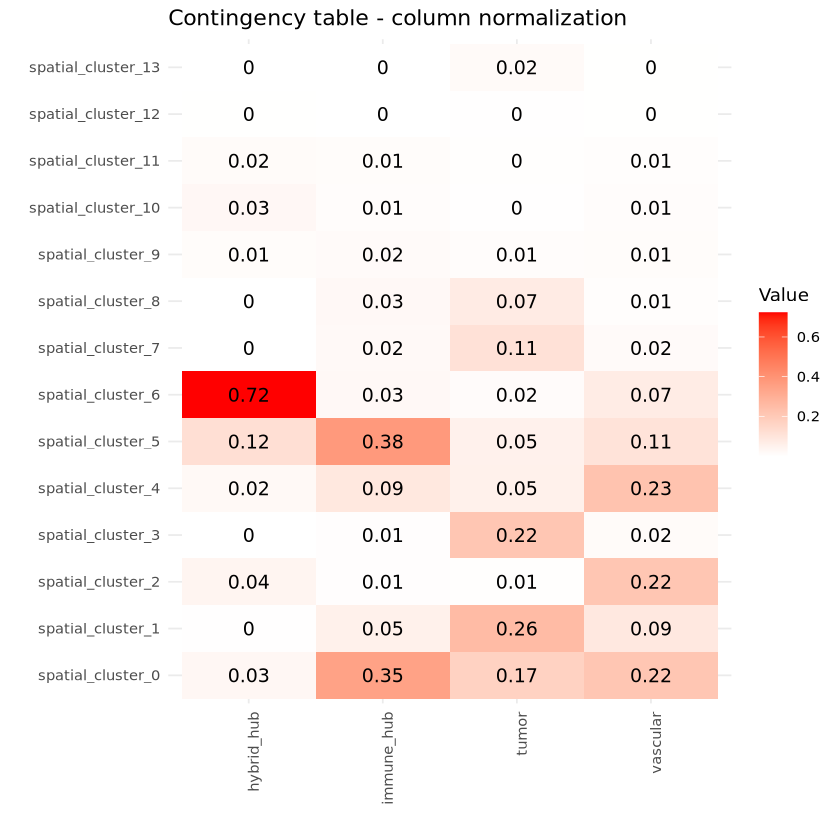

In [143]:
plot_heatmap(colnorm_contin, title='Contingency table - column normalization')

In [128]:
# Normalize across rows
rownorm_contin = sweep(contingency,1, rowSums(contingency), "/")
rownorm_contin

,hybrid_hub,immune_hub,tumor,vascular
spatial_cluster_0,1.457137e-02,0.190693393,0.50617619,0.28855905
spatial_cluster_1,1.258796e-03,0.033199605,0.83670069,0.12884091
spatial_cluster_2,5.619872e-02,0.011350481,0.04733981,0.88511099
spatial_cluster_3,7.463429e-05,0.005336352,0.96209822,0.03249080
spatial_cluster_4,2.281494e-02,0.091509596,0.30643222,0.57924325
spatial_cluster_5,1.044077e-01,0.369954796,0.27372471,0.25191275
spatial_cluster_6,6.961052e-01,0.027085362,0.08859137,0.18821811
spatial_cluster_7,1.296321e-03,0.033547897,0.90197130,0.06318448
spatial_cluster_8,1.664060e-04,0.055912404,0.89652877,0.04739242
spatial_cluster_9,8.939537e-02,0.138521493,0.51913085,0.25295229


Warning message:
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is superseded and is no longer actively developed, and this redirection is now deprecated. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace, i.e. reshape2::melt(data). In the next version, this warning will become an error.”


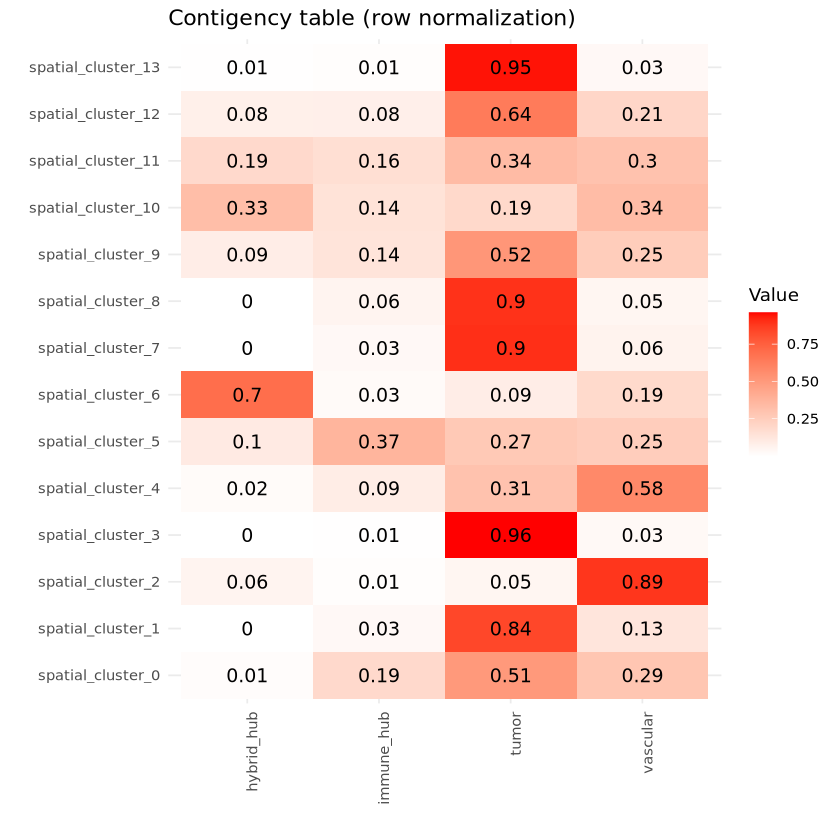

In [144]:
plot_heatmap(rownorm_contin, title='Contigency table (row normalization)')

## Spatial overlapping